# Entity Resolution Practice and Text Analytics

## This lab is inspired from a lab in Berkeley's CS100, however with a new dataset there are new challenges

## Entity resolution is the process of matching too apparently divergent records.  
## For example, if you have two songs in your music library and both are the same song, but have different spellings for the artist or other metadata then they will be incorrectly labeled as two distinct entities.  This leads to a lower quality experience when dealing with a music library.

## Similarly, two distinct records may inadvertantly be added to a dataset due to errors in the data entry process.  

## Deduplication or Entity Resolution seeks to minimize records duplicates by reconciling them based on feature similarity.  This is called <u> Cross linking </u>.

## This lab will use the Abt-Buy dataset, so let's get it first

In [1]:
import zipfile
import urllib
import os
import re

url = 'http://dbs.uni-leipzig.de/file/Abt-Buy.zip';
dest_directory = os.path.join("../../data/MyData", "abt")

def getData():
    global url
    global dest_directory
    #data = urllib.urlopen(url)
    
    abt_zipfile_name = "abt.zip"
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    
    abt_zip_path = os.path.join(dest_directory, abt_zipfile_name)
    if not os.path.exists(abt_zip_path):
        abt_zip = urllib.urlopen(url)
        # write it to file
        with open(abt_zip_path, "wb") as fh:
            fh.write(abt_zip.read())
        
    if not all(map(lambda f_name: os.path.exists(os.path.join(dest_directory, f_name)), ["Abt.csv", "Buy.csv", 'abt_buy_perfectMapping.csv'])):
        with zipfile.ZipFile(abt_zip_path, 'r') as zf:
            zf.extractall(dest_directory)
            
    
    
    
getData()

## Now that you have the data, read it in and check the first few lines of each file

In [2]:
STOPWORDS_FILE = "../../data/cs100/lab3/stopwords.txt"
ABT_FILE, BUY_FILE, GOLD_STANDARD = ("Abt.csv", "Buy.csv", 'abt_buy_perfectMapping.csv')




In [3]:
""" Don't run this, it was used to test the upcoming functions
ABT_FILE_RDD = sc.textFile(os.path.join(dest_directory, ABT_FILE))
BUY_FILE_RDD = sc.textFile(os.path.join(dest_directory, BUY_FILE))
GOLD_STANDARD_RDD = sc.textFile(os.path.join(dest_directory, GOLD_STANDARD))
STOPWORDS = sc.textFile(STOPWORDS_FILE)
"""

" Don't run this, it was used to test the upcoming functions\nABT_FILE_RDD = sc.textFile(os.path.join(dest_directory, ABT_FILE))\nBUY_FILE_RDD = sc.textFile(os.path.join(dest_directory, BUY_FILE))\nGOLD_STANDARD_RDD = sc.textFile(os.path.join(dest_directory, GOLD_STANDARD))\nSTOPWORDS = sc.textFile(STOPWORDS_FILE)\n"

In [4]:
#print map(lambda array: ",".join(array), ABT_FILE_RDD.map(lambda entry: entry.split(",")).filter(lambda split_entry: split_entry[-1]!="").take(2))

#abt_sample_line = ABT_FILE_RDD.take(3)[1]

In [5]:

#print BUY_FILE_RDD.take(10)[9]
#buy_sample_line = BUY_FILE_RDD.take(1)[0]

In [6]:
#print GOLD_STANDARD.take(2)

In [7]:
#print STOPWORDS.take(2)

## Now let's make parsing functions and regex to put it into a conformable structure

## structures for the data


In [8]:
ABT_RE = re.compile(r'(?P<id>.+),"(?P<name>.*)","(?P<description>.*)",(?P<price>.*)')
BUY_RE = re.compile(r'(?P<id>[0-9A-Za-z]+),"?(?P<name>.*)"?,"?(?P<description>.*)"?,"?(?P<manufacturer>.*)"?,(?P<price>.*)')
GOLD_RE = re.compile(r'"?(.+)"?,"?(.+)"?')

In [9]:
import re

def parseDataLine(line, regx):
    
    match = regx.match(line)
    print match
    if match and match.group(1).strip('"').startswith("id"):
        print "Headerline:{}".format(line)
        return (line, 0)
    elif match is None:
        print "Error in reading line: {}".format(line)
        return (line, -1)
    # gold standard
    elif len(match.groups()) == 2:
        return (match.group(1), match.group(2), 1)
        
    else:
        match_dict = match.groupdict()
        return (match_dict.pop('id'), match_dict, 1)
    




## Test the regex on all the data

In [10]:
#print GOLD_STANDARD_RDD.take(2)[1]
#parseDataLine(GOLD_STANDARD_RDD.take(1)[0], GOLD_RE)

In [11]:
#print parseDataLine(abt_sample_line, ABT_RE)

In [12]:
#print ABT_RE.match(abt_sample_line).group(1)
#print abt_sample_line
#print ABT_RE

In [13]:
#print parseDataLine(buy_sample_line, BUY_RE )

## Streamline the data acquisition process
### uncomment above lines to debug the regex process

In [14]:
def parseData(filePath,regx):
    """Parse data file
    Args:
        filePath (str): input file name complete
    Returns:
        rdd with parsed lines"""
    return sc.textFile(filePath, 4,0).map(lambda l: parseDataLine(l,regx))
    

def loadDataFile(file_name, regx):
    file_path = os.path.join(dest_directory, file_name)
    
    all_lines = parseData(file_path, regx)
    
    bad_lines = all_lines.filter(lambda t: t[-1]==-1).map(lambda t: t[0])
    good_lines = all_lines.filter(lambda t: t[-1]==1).map(lambda t: t[:-1]).cache()
    header_lines = all_lines.filter(lambda t: t[-1]==0).map(lambda t: t[0])
    
    
    print "Bad lines count: {}".format(bad_lines.count())
    for bad_line in bad_lines.take(10):
        print bad_line
        
    for header_line in header_lines.take(10):
        print header_line
        
    print "Good lines: {}\nBad lines:{}\nTotal lines:{}".format(good_lines.count(), bad_lines.count(), all_lines.count())
    
    return good_lines
    
    
    
    
parsed_abt_rdd = loadDataFile(ABT_FILE, ABT_RE)
parsed_gold_rdd = loadDataFile(GOLD_STANDARD, GOLD_RE)
parsed_buy_rdd = loadDataFile(BUY_FILE, BUY_RE)

Bad lines count: 0
"id","name","description","price"
Good lines: 1081
Bad lines:0
Total lines:1082
Bad lines count: 0
"idAbt","idBuy"
Good lines: 1097
Bad lines:0
Total lines:1098
Bad lines count: 1
"id","name","description","manufacturer","price"
Good lines: 1092
Bad lines:1
Total lines:1093


In [15]:
# look at data
for i in parsed_abt_rdd.take(10):
    print i

('552', {'price': '', 'description': 'Sony Turntable - PSLX350H/ Belt Drive System/ 33-1/3 and 45 RPM Speeds/ Servo Speed Control/ Supplied Moving Magnet Phono Cartridge/ Bonded Diamond Stylus/ Static Balance Tonearm/ Pitch Control', 'name': 'Sony Turntable - PSLX350H'})
('580', {'price': '$399.00', 'description': "Bose Acoustimass 5 Series III Speaker System - AM53BK/ 2 Dual Cube Speakers With Two 2-1/2' Wide-range Drivers In Each Speaker/ Powerful Bass Module With Two 5-1/2' Woofers/ 200 Watts Max Power/ Black Finish", 'name': 'Bose Acoustimass 5 Series III Speaker System - AM53BK'})
('4696', {'price': '$49.00', 'description': 'Sony Switcher - SBV40S/ Eliminates Disconnecting And Reconnecting Cables/ Compact Design/ 4 A/V Inputs With S-Video Jacks/ 1 A/V Output With S-Video (Y/C)Jack/ 2 Audio Output', 'name': 'Sony Switcher - SBV40S'})
('5644', {'price': '', 'description': 'Sony 5 Disc CD Player- CDPCE375/ 5 Disc Changer/ Variable Line Output/ CD-R/RW Playback Capability/ 20 Track Mu

## Are there any instances where price is not empty and is not a monetary amount?

In [16]:
def checkPrice(dataRDD):
    priceless = dataRDD.filter(lambda (id, data): data['price'] != "" and "$" not in data['price'])
    
    print "There were {} cases where price was neither a monetary amount or an empty string".format(priceless.count())
    
    for i in priceless.take(20):
        print i

checkPrice(parsed_abt_rdd)
checkPrice(parsed_buy_rdd)



There were 0 cases where price was neither a monetary amount or an empty string
There were 77 cases where price was neither a monetary amount or an empty string
('205593354', {'price': '698.00"', 'description': 'Denon"', 'name': 'Denon AVR-3808CI A/V Receiver - AVR3808CI","Dolby Pro Logic IIx, Dolby Digital Surround, DTS-ES, DTS Neo:6, DTS 96/24, Neural SurroundFM, AM, XM"', 'manufacturer': '$1'})
('205593367', {'price': '849.77"', 'description': 'Denon"', 'name': 'Denon AVR-4308CI A/V Receiver - AVR4308CI","Dolby Pro Logic IIx, Dolby Digital Surround, DTS-ES, DTS Neo:6, DTS 96/24, Neural SurroundFM, AM, XM"', 'manufacturer': '$1'})
('205599985', {'price': '029.88"', 'description': 'Canon"', 'name': 'Canon EOS 40D Digital SLR Camera with EF 28-135mm f/3.5-5.6 IS USM Lens - 1901B017","Canon EOS 40D Digital SLR Camera with 28-135mm Lens"', 'manufacturer': '$1'})
('206419131', {'price': '521.09"', 'description': 'Nikon"', 'name': 'Nikon D300 Digital SLR Camera - 25432","12.3 Megapixel - 3

## a lot of weirdness going on with the buy dataset, the manufacturer,description and other fields seem to not match up

## we'll be using the bag of words approach for conflation, so the key is to make a list that contains all the words from these rdd with stopwords and punctuation removed

In [17]:
def joinTextFromRDD(dataRDD):
    """ put the text from the description name and if it has a manufacturer into a list of words
    Args:
        dataRDD(rdd): rdd that has following format (id, data_dict)
    Returns:
        RDD: has form (id, string containing all words from description)
    """
    
    return (dataRDD
            .map(lambda (id, data): (id,                       #spark map accross rows
                                     map(lambda t: t[1],       #get the values from tuple of data entries
                                           filter(lambda t: t[0] != 'price', tuple(data.items())))))  #convert data dict to tuple
            .map(lambda (id, list_): (id, " ".join(              #spark map a list to a string
                    map(lambda element: element.strip('"'), list_ #give spark map cleaned quotes elements
                                                      )))))
    
joined_buy_rdd = joinTextFromRDD(parsed_buy_rdd)
joined_abt_rdd = joinTextFromRDD(parsed_abt_rdd)

## Bag of words operates on finding similar tokens across documents.  Tokens are the atomic unit of comparison amongst strings

### To implement this behavior we will make a function that returns tokens from a string of words

In [18]:
import string

test_string = 'D-Link D-Link Broadband Cable Modem D-Link Express EtherNetwork High-Speed DOCSIS 2.0 Cable Modem - DCM-202'


def processAndTokenize(string_):
    """Returns a list of words that have been filtered for punctuations and are lowered
    Args:
        string (str): string to split
    Returns:
        list: list of tokens"""
    return filter(lambda token: token not in string.punctuation, 
                  map(lambda filtered_word: filtered_word.strip(string.punctuation),
                    map(lambda word: re.sub(r'[\',]',"", word.lower()), re.split(r'[\s]', string_))))

processAndTokenize(test_string)

['d-link',
 'd-link',
 'broadband',
 'cable',
 'modem',
 'd-link',
 'express',
 'ethernetwork',
 'high-speed',
 'docsis',
 '2.0',
 'cable',
 'modem',
 'dcm-202']

In [19]:
inter_word_dash = r'\w+-\w+'
re.match(inter_word_dash, "walk-man")

## Also get rid of all stopwords

In [20]:
stop_words = sc.textFile(STOPWORDS_FILE).collect()

In [21]:
print "STopwords are:"
for i in stop_words:
    print i
    
def tokenize(string_):
    return filter(lambda token: token not in stop_words, processAndTokenize(string_))
    
print tokenize("hello, world")

STopwords are:
all
just
being
over
both
through
yourselves
its
before
herself
had
should
to
only
under
ours
has
do
them
his
very
they
not
during
now
him
nor
did
this
she
each
further
where
few
because
doing
some
are
our
ourselves
out
what
for
while
does
above
between
t
be
we
who
were
here
hers
by
on
about
of
against
s
or
own
into
yourself
down
your
from
her
their
there
been
whom
too
themselves
was
until
more
himself
that
but
don
with
than
those
he
me
myself
these
up
will
below
can
theirs
my
and
then
is
am
it
an
as
itself
at
have
in
any
if
again
no
when
same
how
other
which
you
after
most
such
why
a
off
i
yours
so
the
having
once
['hello', 'world']


In [22]:
abtTokenized = joined_abt_rdd.map(lambda (id, string_): (id, tokenize(string_))).cache()
buyTokenized = joined_buy_rdd.map(lambda (id, string_): (id, tokenize(string_))).cache()

In [23]:
for i in buyTokenized.take(10):
    print i 

('10011646', ['linksys', 'linksys', 'etherfast', '8-port', '10/100', 'switch', 'new/workgroup', 'linksys', 'etherfast', 'ezxs88w', 'ethernet', 'switch', 'ezxs88w'])
('10140760', ['linksys', '5', 'x', '10/100base-tx', 'lan', 'linksys', 'etherfast', 'ezxs55w', 'ethernet', 'switch'])
('10221960', ['netgear', 'netgear', 'fs105', 'prosafe', '5', 'port', '10/100', 'desktop', 'switch', 'netgear', 'prosafe', 'fs105', 'ethernet', 'switch', 'fs105na'])
('10246269', ['belkin', '1', 'x', 'hd-15', '1', 'x', 'hd-15', '10ft', 'beige', 'belkin', 'pro', 'series', 'high', 'integrity', 'vga/svga', 'monitor', 'extension', 'cable', 'f3h982-10'])
('10315184', ['netgear', 'netgear', 'prosafe', '16', 'port', '10/100', 'rackmount', 'switch', 'jfs516na', 'netgear', 'prosafe', 'jfs516', 'ethernet', 'switch'])
('10316920', ['lacie', 'lacie', 'pocket', 'usb', 'floppy', '1.44', 'mb', 'lacie', 'pocket', 'floppy', 'disk', 'drive', '706018'])
('10326220', ['canon', '36', 'page', '4', 'x', '6', 'canon', 'kp', '36ip', '

## Count distinct tokens

In [24]:
def countTokens(tokenizedRDD):
    return tokenizedRDD.flatMap(lambda t:t[1]).distinct().count()

print "ther are {} distinct tokens in the abt data set, and {} distinct tokens in the buy dataset. total: {}".format(
    countTokens(abtTokenized), countTokens(buyTokenized), countTokens(abtTokenized)+countTokens(buyTokenized))

ther are 5953 distinct tokens in the abt data set, and 3340 distinct tokens in the buy dataset. total: 9293


In [25]:
# biggest token
abtTokenized.map(lambda t: len(t[1])).max()

82

# Now for methods that detect duplicates

## In bag of words, we compare the similarity of tokens across two records.  
## Weights are given to each token in accordance with rarity accross all records and occurence between two records

In [26]:
# first try implementing an unweighted token counting algorithm
from collections import defaultdict

def dictOfTokens(list_of_tokens):
    dict_tokens = defaultdict(int)
    for i in list_of_tokens:
        dict_tokens[i] += 1
    return dict_tokens

dict1= dictOfTokens(["apple", "apple", "banana"])
dict2= dictOfTokens(["banana", "banana","apple",  "banana"])

In [27]:
def similarityOfDicts(dict1, dict2):
    """computes similarity of tokens accross two records by favoring those records that have equal occurences of similar
    tokens accross the records
    """
    joined_dict = defaultdict(int)
    for k in dict1:
        joined_dict[k] += dict1[k]
    for k in dict2:
        joined_dict[k] -= dict2[k]
    return joined_dict

print similarityOfDicts(dict1, dict2)

defaultdict(<type 'int'>, {'apple': 1, 'banana': -2})


In [28]:
def divergenceOfDicts(joined_dict):
    return reduce(lambda x,y: x+y, map(lambda (k,v): abs(v), joined_dict.items()))

print divergenceOfDicts(similarityOfDicts(dict1,dict2))

3


## This naive way works by selecting those records that have low divergence of terms between them

## try it on the dataset

In [29]:
cart = (abtTokenized.cartesian(buyTokenized)
        .map(lambda t: ((t[0][0], t[1][0]), (dictOfTokens(t[0][1]), dictOfTokens(t[1][1]))))
        .map(lambda t: (t[0], divergenceOfDicts(similarityOfDicts(*t[1])))))

In [30]:
duplicates = cart.filter(lambda t: t[1] < 20).map(lambda t: t[0])

## test on the gold standard to see how many possible duplicates we caught

In [31]:
duplicates.intersection(parsed_gold_rdd).count()

72

## which is 72/total_true = 

In [32]:
float(72)/parsed_gold_rdd.count()

0.06563354603463993

## now I will try it with difference thresholds

```python
#this takes a long time so i commented it out
best_threshold = None
best_percentage = 0
total_gold_counts = parsed_gold_rdd.count()
for thresh in range(10,100,10):
    current_duplicates = cart.filter(lambda t: t[1] < thresh).map(lambda t: t[0])
    intersected_counts = current_duplicates.intersection(parsed_gold_rdd).count()
    percentage = float(intersected_counts)/total_gold_counts
    print "For threshold of {}, the intersected counts are {} and percent of true caught is: {}".format(
        thresh, intersected_counts, percentage)
    if percentage > best_percentage:
        best_percentage = percentage
        best_threshold = thresh

```

## eventually as the threshold increases, we can expect to see all dupes being matched, this is because the maximum divergence is only 120.  We are including lots of false positives

<h1 style="width:30%;display:inline; border: solid 2px black;">Entity Resolution Algorithms</h1>
<h1 style="width:49%; border: solid 2px black;display:inline">And Definitions</h1>


<style>
th {color:red;}
</style>

<table class="algorithms">
    <thead>
        <tr>
            <th scope="col">Algorithm Name</th>
            <th scope="col">Description</th>
        </tr> 
    </thead>
    <tbody>
        <tr>
            <td>TF-IDF</td>
            <td>Term-Frequency/Inverse-Document-Frequency works by assigning weights to tokens based on their rarity and frequency of occurences. it is the product of TF and IDF
                $$\text{TF-IDF}(t)=TF(t)*IDF(t)$$
                where t is a token
            </td>
        </tr>
        <tr>
            <td>Term-Frequency</td>
            <td>It is the proportion of token relative to all the tokens in a document and is calculated by <br>
                $$TF(\text{token})=\frac{count\text{(token)}}{count(\text{allTokensInDocument)}}$$
                Essentially, if a token appears inside a document numerous times, then it must be critical to the semantics of the document.
            </td>
        </tr>
        <tr>
            <td>Inverse-Document-Frequency</td>
            <td>If two documents share a word that is rare in the overall dataset, then the probability that the two
            documents being similar is increased. Given a set of documents $U$ with cardinality $N$, the IDF of a token $t$ is
                
                $$IDF(t) = \frac{N}{n(t)} $$
                Where $n(t)$ is the number of documents containing token $t$
            </td>
        </tr>
    </tbody>
    <tfoot>
        <tr>
            <td colspan=2> There are a lot more that you can use </td>
        </tr>
       
    </tfoot>
</table>

## Now I am going to make a function that calculates the term frequencies of tokens in a set

In [33]:
def termFrequency(tokens):
    """Calculates the term frequencies of a set of tokens
    Args
        tokens (list): list of tokens
    Returns
        (dict): a dictionary of tokens with associated term frequencies
    """
    tf = defaultdict(int)
    for i in tokens:
        tf[i] += 1
    return dict(map(lambda (k,v): (k,float(v)/len(tokens)), tf.items()))

termFrequency(["banana", "banana","apple",  "banana"])



{'apple': 0.25, 'banana': 0.75}

## Now, I need to create IDFs for all terms 
## Heres the formula again, $IDF(t) = \frac{N}{n(t)}$

In [34]:
def idf(rdd):
    N = rdd.count()
    
    allTerms = rdd.flatMap(lambda t: set(t[1]))
    countTerms = allTerms.map(lambda term: (term, 1))
    termPerDocument = countTerms.reduceByKey(lambda x,y: x+y)
    return termPerDocument.mapValues(lambda v: N/float(v))

idf(abtTokenized).takeOrdered(10, lambda t:t[1])

[('finish', 1.321515892420538),
 ('black', 2.00556586270872),
 ('digital', 3.5913621262458473),
 ('system', 4.523012552301255),
 ('lcd', 4.741228070175438),
 ('sony', 5.93956043956044),
 ('built-in', 6.0055555555555555),
 ('display', 6.284883720930233),
 ('compatible', 6.473053892215569),
 ('technology', 6.714285714285714)]

## gather all the documents from both sides and place them into one corpus

In [35]:
corpus = abtTokenized.union(buyTokenized)

#for i in corpus.sample(False, .1).collect():
 #   print i

In [36]:
idfs = idf(corpus)

In [37]:
idfs.takeOrdered(100, lambda (k,v):v)

[('finish', 2.653235653235653),
 ('black', 3.0391608391608393),
 ('digital', 4.555555555555555),
 ('lcd', 5.392059553349876),
 ('sony', 6.036111111111111),
 ('system', 7.416382252559727),
 ('x', 9.366379310344827),
 ('hdtv', 9.96788990825688),
 ('camera', 10.757425742574258),
 ('panasonic', 10.757425742574258),
 ('built-in', 11.436842105263159),
 ('series', 11.93956043956044),
 ('display', 11.93956043956044),
 ('canon', 12.139664804469273),
 ('control', 12.27683615819209),
 ('compatible', 12.857988165680473),
 ('technology', 13.331288343558283),
 ('video', 13.496894409937887),
 ('2', 13.58125),
 ('panel', 13.753164556962025),
 ('memory', 13.840764331210192),
 ('1080p', 14.486666666666666),
 ('dvd', 14.583892617449665),
 ('color', 14.782312925170068),
 ('3', 14.782312925170068),
 ('zoom', 14.782312925170068),
 ('resolution', 16.096296296296295),
 ('5', 16.096296296296295),
 ('tv', 16.21641791044776),
 ('megapixel', 16.46212121212121),
 ('contrast', 16.715384615384615),
 ('1', 16.8449612

## to see a distribution of the idfs use a histogram


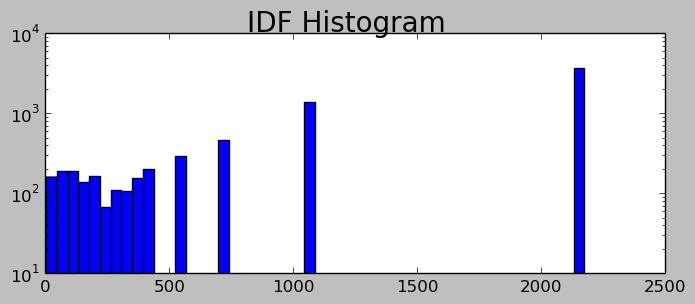

In [38]:
import matplotlib.pyplot as plt

idf_vals = idfs.map(lambda (k,v): v).collect()
fig = plt.figure(figsize=(8,3))
thePlot = plt.hist(idf_vals, bins=50, log=True)
fig.suptitle("IDF Histogram", fontsize=20)

## Now that we have IDF and TF functions, the next step is to calculate the tf-idf of a token

## this function will need to take in an idfs dictionary, so it is best to broadcast the idf dictionary

In [39]:
idfs_broadcast = sc.broadcast(idfs.collectAsMap())

In [40]:
def tf_idf(tokens, idfs):
    tf_dict = termFrequency(tokens)
    return dict(map(lambda (k,v): (k,v*idfs.get(k,0)), tf_dict.items()))


In [41]:
(test_id,test_tokens) = abtTokenized.take(1)[0]

print "testing abt id: {}: it has tokens: {}".format(test_id,tf_idf(test_tokens, idfs_broadcast.value))

testing abt id: 552: it has tokens: {'control': 0.8466783557373855, '33-1/3': 74.93103448275862, 'turntable': 9.366379310344827, 'static': 74.93103448275862, 'pitch': 74.93103448275862, 'tonearm': 74.93103448275862, 'speed': 1.4692359702501692, 'bonded': 74.93103448275862, 'pslx350h': 149.86206896551724, 'servo': 12.488505747126437, 'rpm': 5.763925729442971, '45': 10.704433497536947, 'system': 0.2557373190537837, 'supplied': 24.977011494252874, 'belt': 5.352216748768473, 'diamond': 10.704433497536947, 'cartridge': 1.6651340996168582, 'moving': 74.93103448275862, 'sony': 0.41628352490421455, 'phono': 24.977011494252874, 'stylus': 10.704433497536947, 'drive': 0.7805316091954023, 'magnet': 14.986206896551725, 'balance': 14.986206896551725, 'speeds': 9.366379310344827}


## Next step is to get the cosine similarity between  two different document tokens

In [42]:
def dot(dict_values_a, dict_values_b):
    return sum(map(lambda k: dict_values_a.get(k,0) * dict_values_b.get(k,0), dict_values_a.keys()))

def norm(dict_values):
    return sum(map(lambda v: v*v, dict_values.values()))**.5

def cossim(values_a, values_b):
    """ Calculates the cosine similarity between two set of tokens with their associated weights
    Args:
        values_a (dict): dict with tokens as keys and weights as values
        values_b (dict): dict with tokens as keys and weights as values
    Returns:
        float: cosine similarity between two records
    """
    return dot(values_a, values_b)/norm(values_a)/norm(values_b)
    

In [43]:
abt_sample_id,buy_sample_id = parsed_gold_rdd.take(2)[1]
sample_record_abt = abtTokenized.filter(lambda t: t[0] == abt_sample_id).map(lambda (k,v): tf_idf(v, idfs_broadcast.value)).collect()[0]
sample_record_buy = buyTokenized.filter(lambda t: t[0]== buy_sample_id).map(lambda (k,v): tf_idf(v, idfs_broadcast.value)).collect()[0]
sample_record_abt

{'10/100': 9.551648351648351,
 '100basetx': 31.04285714285714,
 '100mbps': 62.08571428571428,
 '10baset': 31.04285714285714,
 '10mbps': 62.08571428571428,
 '200mbps': 15.52142857142857,
 '20mbps': 62.08571428571428,
 '5': 0.45989417989417986,
 '5-port': 41.39047619047619,
 'auto-sensing': 124.17142857142856,
 'autosensing': 20.695238095238096,
 'duplex': 6.898412698412699,
 'etherfast10/100': 124.17142857142856,
 'ezxs55w': 62.08571428571428,
 'full': 0.5446115288220552,
 'half': 15.52142857142857,
 'hardware': 6.898412698412699,
 'integrating': 62.08571428571428,
 'linksys': 3.1042857142857145,
 'modes': 2.002764976958525,
 'network': 1.8813852813852812,
 'perfect': 8.869387755102041,
 'port': 1.7246031746031747,
 'ports': 6.535338345864662,
 'run': 20.695238095238096,
 'switch': 2.956462585034014,
 'switched': 20.695238095238096}

In [44]:
sample_cosim = cossim(sample_record_abt,sample_record_buy )
print sample_cosim

0.237964471568


In [45]:
def getCosineSimilarity(string1, string2):
    """Returns the cosine similarity between two documents.  Broadcast variable is used for idfs"""
    return cossim(tf_idf(tokenize(string1), idfs_broadcast.value), 
                         tf_idf(tokenize(string2), idfs_broadcast.value))


## Now we can make a cartesian product of all our records from one data set to another and then see which pairs produce the lowest cosine similarity

In [46]:
cartStrings = joined_abt_rdd.cartesian(joined_buy_rdd).cache()


In [47]:
def calculateSimilarity(rec):
    abt_record = rec[0]
    buy_record = rec[1]
    
    abt_id, abt_string = abt_record
    buy_id, buy_string = buy_record
    
    return (abt_id, buy_id, getCosineSimilarity(abt_string, buy_string))
    

In [48]:
cosineSimilarties = cartStrings.map(calculateSimilarity).cache()
cosineSimilarties.cache()

PythonRDD[112] at RDD at PythonRDD.scala:43

In [49]:
def getSimilarity(abt_id, buy_id):
    return cosineSimilarties.filter(
        lambda (a,b,c): a==abt_id and b==buy_id).map(
        lambda (a,b,c): c).collect()[0]

In [50]:
print parsed_gold_rdd.take(5)

[('38477', '10011646'), ('38475', '10140760'), ('33053', '10221960'), ('27248', '10246269'), ('25262', '10315184')]


## Average cosimilarity between actual duplicates is 0.2098705146493882

In [51]:
sims = cosineSimilarties.map(lambda args: ("{} {}".format(*args[:2]), args[2]))
sims.cache()


PythonRDD[114] at RDD at PythonRDD.scala:43

In [52]:
gold_formatted = parsed_gold_rdd.map(lambda t: ("{} {}".format(*t), 0))
gold_formatted.take(1)


[('38477 10011646', 0)]

## A quick refresher on joins, the output is that keys present in both data sets are in the final set, and the values are a tuple of their original values


In [53]:
a = sc.parallelize(zip(('a', 'b', 'c'), range(3)))
b = sc.parallelize([('c', 4)])

In [54]:
a.join(b).take(1)

[('c', (2, 4))]

## The next few steps show the joining of the duplicates rdd with the similarities rdd along with the antijoin of the duplicates rdd with the similarities rdd (to get the non-duplicates)

In [ ]:
trueDups = sims.join(gold_formatted).map(lambda t: (t[0], t[1][0])).cache()
trueDups.take(1)

In [ ]:
trueDups.map(lambda t: t[1]).mean()

In [ ]:
nonDupes = sims.leftOuterJoin(gold_formatted).filter(lambda t: t[1][1] == None).cache()

In [ ]:
nonDupes.map(lambda t: t[1][0]).mean()

## A good threshold for testing for duplicity is therefore about .20

# <span style="color:blue">A faster way of entity resolution using distributive computing</span>

Instead of checking to see if a document contains a token.  A better way to find out which documents are similar is by using an inverse index that uses the tokens as the keys and the values are the documents that contain those tokens.  Now there is no need to search every document to see which are similar.  Just use the inverse index.  

By the way, inverse indexes are also called concordances.  They are similar to indexes in the back of most books, however concordances were often used to indicate which text a reader would most likely use in a library.



In [ ]:
#get the weights of both data sets
abtWeights = abtTokenized.mapValues(lambda x: tf_idf(x, idfs_broadcast.value))
buyWeights = buyTokenized.mapValues(lambda x: tf_idf(x, idfs_broadcast.value))

print abtWeights.count()
print buyWeights.count()
                                                    

In [ ]:
# compute the norms
abtNorms = abtWeights.mapValues(norm)
buyNorms = buyWeights.mapValues(norm)

# broadcast them for later use
abtNormsBroadcast, buyNormsBroadcast = map(lambda x: sc.broadcast(x.collectAsMap()), [abtNorms, buyNorms])

print abtNorms.take(1)
print buyNorms.take(1)

## Make the inverted indices by inverting the token and id pairs in the weights rdd

In [ ]:
def invert(record):
    id = record[0]
    return map(lambda t: (t,id), record[1])

In [ ]:
abtInv = abtWeights.flatMap(invert).cache()
buyInv = buyWeights.flatMap(invert).cache()

In [ ]:
abtInv.take(1)

In [ ]:
# join the two data sets
common_tokens = (abtInv.join(buyInv).map(lambda record: (record[1], record[0]))
        .reduceByKey(lambda token1, token2: token1+' '+token2).mapValues(lambda x: x.split())).cache()

In [ ]:
common_tokens.take(10)

## Now compute the cosine similarity...again

In [ ]:
abtWeightsBroadcast = sc.broadcast(abtWeights.collectAsMap())
buyWeightsBroadcast = sc.broadcast(buyWeights.collectAsMap())
def invCosineSimilarties(record):
    abt_id = record[0][0]
    buy_id = record[0][1]
    
    abt_rec = abtWeightsBroadcast.value.get(abt_id)
    buy_rec = buyWeightsBroadcast.value.get(buy_id)
    
    common_tokens = record[1]
    tokens_sum = sum(map(lambda t: abt_rec.get(t)*buy_rec.get(t), common_tokens ))
    
    rv = tokens_sum / abtNormsBroadcast.value.get(abt_id)/ buyNormsBroadcast.value.get(buy_id)
    
    key = abt_id, buy_id
    
    return (key, rv)
    

In [ ]:
similaritiesRdd = (common_tokens.map(invCosineSimilarties).cache())

In [ ]:
similaritiesRdd.map(lambda (k,v): v).mean()

<hr>
# Evaluation
<hr>

#### Now that we have a method of comparing document similarities it's time to evaluate how our model performs.  To start, as before, pick a threshold cosine value to delineate duplicate vs non-duplicate.  Earlier we found that .20 may be a good threshold, but now we will just go through a space of possible threshold values and see which threshold value performs the best.

#### In entity resolution, the effectiveness of a method is measured by three attributes: recall, precision, and F statistic.

#### precision is the number of entries that we labeled as true that were true divided by the number of entries that we said were true and are true plus the number of entries that we erroneously classified as true

#### recall is the number of entries we labeled as true that were actually true divided by the number of entries that we said that were actually true plus the number of entries that were true but we labeled as negative

#### precision: $\frac{tp}{tp + fp}$

#### recall:  $\frac{tp}{tp + fn}$

#### f1 statistic: $2\frac{\text{precision}*\text{recall}}{\text{precision}+\text{recall}}$


<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg">

<a href="https://commons.wikimedia.org/wiki/File:Precisionrecall.svg#/media/File:Precisionrecall.svg">Precisionrecall</a>" by <a href="//commons.wikimedia.org/wiki/User:Walber" title="User:Walber">Walber</a> - <span class="int-own-work" lang="en">Own work</span>. Licensed under <a href="http://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a> via <a href="https://commons.wikimedia.org/wiki/">Commons</a>.

In [72]:
# first create the similarities rdd with the key as a joined string of the two ids
simRDD = similaritiesRdd.map(lambda (x,y): ((" ").join(x), y))

simValues = simRDD.map(lambda x: x[1]).cache()

In [73]:
simValues.take(5)

[2.3619486845819208e-05,
 4.087265674957665e-06,
 0.012599920137237831,
 0.00040561887369464935,
 0.00010763451035335205]

## Next we join the gold standard rdd

In [75]:
def getGoldStandardValue(record):
    return record[1][1] if record[1][1] else 0

trueDupsSimRDD = (gold_formatted.leftOuterJoin(simRDD).map(getGoldStandardValue).cache())

## The next step is to implement a threshold testing facility by using spark accumulators.  

## For reference, spark accumulators are used to keep track of events inside transformations.  They are typically used with ints but can be user defined by inheriting from AccumulatorParam. The user must override the zero and addInPlace methods. Accumulator behavior can be unpredictable if used improperly or tasks are reran

In [79]:
## this part is directly from the CS100 lab since I couldn't decipher what was going on

from pyspark.accumulators import AccumulatorParam


class VectorAccumulatorParam(AccumulatorParam):
    
    def zero(self, value):
        return [0] * len(value)
    
    def addInPlace(self, val1, val2):
        for i in xrange(len(val1)):
            val1[i] += val2[i]
        return val1

def set_bit(x, value, length):
    bits = []
    for y in xrange(length):
        if (x == y):
          bits.append(value)
        else:
          bits.append(0)
    return bits


BINS = 101
nthresholds = 100

zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())

def bin(similarity):
    return int(similarity * nthresholds)

def add_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, 1, BINS)


simValues.foreach(add_element)

# remove true dups from counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)
    
trueDupsSimRDD.foreach(sub_element)

def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupsSimRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    # out of all the duplicates we will remove the ones that we incorrectly labeled
    return trueDupsSimRDD.count() - falsenegDict[threshold]

In [87]:
def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp)/(tp+falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return (float(tp)/(tp+falsenegDict[threshold]))

def f1(threshold):
    recall_ = recall(threshold)
    precision_ = precision(threshold)
    return (2.0*(recall_*precision_)/(recall_+precision_))


In [88]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

In [89]:
precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [f1(t) for t in thresholds]

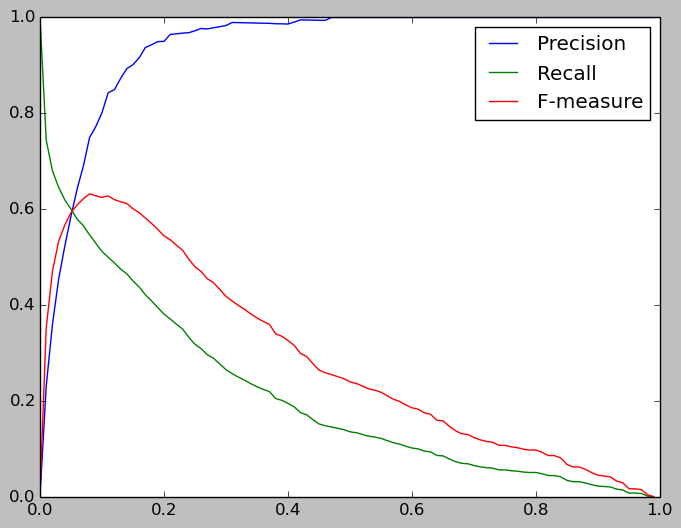

In [90]:
fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
pass

## Looks like the best threshold is about .10, as before, at about .20 cosine value, we are pretty sure that a duplicate is a duplicate, however at this point the boundaries between duplicity are vague so we leave out a bunch of duplicates and falsely label them.

# Next steps use nltk or stemming library to performing stemming on the data before performing cosine similarity